In [1]:
# Main reference for model
# https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost/notebook#Error-Metrics-On-Test-Set

# How XGBoost handles missing values
# https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4

# Why this model doesn't include feature normalisation
# https://datascience.stackexchange.com/questions/60950/is-it-necessary-to-normalize-data-for-xgboost

# Stock values are stated in terms of the closing price and the adjusted closing price. 
# The closing price is the raw price, which is just the cash value of the last transacted price before the market closes.
# The adjusted closing price factors in anything that might affect the stock price after the market closes
# https://www.investopedia.com/terms/a/adjusted_closing_price.asp

# Optuna example
# https://github.com/optuna/optuna-examples/blob/63fe36db4701d5b230ade04eb2283371fb2265bf/xgboost/xgboost_simple.py

# SHAP example
# https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

In [2]:
import xgboost as xgb
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error
import optuna
import shap

# Data Loading

In [3]:
df = pd.read_csv('C:\\Users\\ze179\\Desktop\\sp500_forecast\\data\\data.csv', parse_dates=['Date'])
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close,Ticker,Daily Return %
0,2017-01-03,46.750000,45.740002,45.930000,46.490002,1739600.0,44.659348,A,NaN
1,2017-01-04,47.380001,46.820000,46.930000,47.099998,1821300.0,45.245331,A,0.013121
2,2017-01-05,47.070000,46.360001,47.049999,46.540001,1503700.0,44.707386,A,-0.011890
3,2017-01-06,48.070000,46.560001,46.630001,47.990002,2883400.0,46.100292,A,0.031156
4,2017-01-09,48.560001,47.910000,48.009998,48.139999,2575300.0,46.244389,A,0.003126


# Feature Engineering

In [4]:
# Map tickers to a numeric representation (Used at the end to verify predictions)
tickers_avail = df['Ticker'].unique()
tickers_df = pd.DataFrame({
    'Ticker': tickers_avail,
    'Ticker Number': list(range(len(tickers_avail)))
})

In [5]:
# The model will not accept datetime, hence create a feature for each date part
df["Year"] = df['Date'].dt.year
df["Month"] = df['Date'].dt.month
df["Day"] = df['Date'].dt.day

In [6]:
# Represent tickers as numbers to avoid text values
df['Ticker_Cat'] = pd.Categorical(df['Ticker'])
df['Ticker_Num'] = df['Ticker_Cat'].cat.codes

In [7]:
df.drop(['Ticker', 'Ticker_Cat', 'Close'], inplace=True, axis=1)
# df.drop(['Ticker', 'Ticker_Cat'], inplace=True, axis=1)

# Build objective function to minimize Mean Absolute Percentage Error

In [8]:
def objective(trial):
    
    # Train-Eval split
    ###############################################
    train_split = trial.suggest_float('train_split', 0.7, 0.9, step = 0.05)
    # Set the date at which to split train and eval data
    # Of the unique dates available, pick the split between train and eval dates
    dates_avail = df['Date'].unique()
    split_date_index = int(dates_avail.shape[0] * train_split)
    split_date = dates_avail[split_date_index]
    # Train data is on or before the split date
    train_df = df.query('Date <= @split_date')
    # And eval data is after
    eval_df = df.query('Date > @split_date')
    
    # features = ['Year', 'Month', 'Day', 'High', 'Low', 'Open', 'Close', 'Volume', 'Ticker_Num', 'Daily Return %']
    features = ['Year', 'Month', 'Day', 'High', 'Low', 'Open', 'Volume', 'Ticker_Num', 'Daily Return %']
    label = ['Adj Close']
    x_train = train_df[features]
    y_train = train_df[label]
    x_eval = eval_df[features]
    y_eval = eval_df[label]
    ###############################################
    
    # Build model
    ###############################################
    model = xgb.XGBRegressor(
        n_estimators = trial.suggest_int('n_estimators', 800, 1000, step = 100),
        max_depth = trial.suggest_int('max_depth', 3, 6, step = 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 8, step = 1),
        learning_rate = trial.suggest_float('learning_rate', 0.1, 0.3, step = 0.05)
    )
    model.fit(
        x_train,
        y_train,
        eval_set = [(x_train, y_train), (x_eval, y_eval)],
        early_stopping_rounds = trial.suggest_int('early_stopping_rounds', 20, 50, step = 10),
        verbose = False
    )
    ###############################################
    
    # Evaluate model
    ###############################################
    df_pred = x_eval.copy()
    # Predict data for the eval dataset and save the predicted Adj Close as a new column
    df_pred['Adj Close_Pred'] = model.predict(x_eval)
    
    # Add the true Adj Close into the dataset
    # Indexes were not reset, so we can join on the index (the indexes are reset during the merge though)
    df_pred = df_pred.merge(
        y_eval, 
        how = 'inner', 
        left_index = True, 
        right_index = True
    )
    
    # Mean Absolute Percentage Error is the percentage of how off the predicted values are
    mape = (
        np.abs(df_pred['Adj Close'] - df_pred['Adj Close_Pred']) / df_pred['Adj Close']
    ).mean() * 100

    ###############################################
    return mape

In [9]:
study = optuna.create_study(study_name = 'mape_optimise', direction = "minimize")
study.optimize(objective, n_trials = 10, timeout = 1800)

[I 2022-04-26 23:34:34,388] A new study created in memory with name: mape_optimise
[I 2022-04-26 23:35:40,285] Trial 0 finished with value: 1.44555907223423 and parameters: {'train_split': 0.85, 'n_estimators': 1000, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.25, 'early_stopping_rounds': 30}. Best is trial 0 with value: 1.44555907223423.
[I 2022-04-26 23:37:56,930] Trial 1 finished with value: 1.770092801167374 and parameters: {'train_split': 0.85, 'n_estimators': 1000, 'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.1, 'early_stopping_rounds': 50}. Best is trial 0 with value: 1.44555907223423.
[I 2022-04-26 23:38:37,494] Trial 2 finished with value: 2.5936882607715197 and parameters: {'train_split': 0.7, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 3, 'learning_rate': 0.3, 'early_stopping_rounds': 30}. Best is trial 0 with value: 1.44555907223423.
[I 2022-04-26 23:39:50,185] Trial 3 finished with value: 2.4574715231055846 and parameters: {'train_s

In [10]:
best_trial = study.best_trial
best_params = best_trial.params
best_value = best_trial.value
print(f'Number of finished trials: {len(study.trials)}')
print(f'Best trial\'s optimised Mean Absolute Percentage Error: {round(best_value, 2)}%')

Number of finished trials: 10
Best trial's optimised Mean Absolute Percentage Error: 1.41%


# Recreate model using best parameters

## Train-Eval split

In [11]:
train_split = best_params['train_split']
# Set the date at which to split train and eval data
# Of the unique dates available, pick the split between train and eval dates
dates_avail = df['Date'].unique()
split_date_index = int(dates_avail.shape[0] * train_split)
split_date = dates_avail[split_date_index]
# Train data is on or before the split date
train_df = df.query('Date <= @split_date')
# And eval data is after
eval_df = df.query('Date > @split_date')

# features = ['Year', 'Month', 'Day', 'High', 'Low', 'Open', 'Close', 'Volume', 'Ticker_Num', 'Daily Return %']
features = ['Year', 'Month', 'Day', 'High', 'Low', 'Open', 'Volume', 'Ticker_Num', 'Daily Return %']
label = ['Adj Close']
x_train = train_df[features]
y_train = train_df[label]
x_eval = eval_df[features]
y_eval = eval_df[label]

## Build model

Good set of parameters
* n_estimators: 1000
* max_depth: 5
* min_child_weight: 2
* learning_rate: 0.3
* early_stopping_rounds: 20

In [12]:
model = xgb.XGBRegressor(
    n_estimators = best_params['n_estimators'],
    max_depth = best_params['max_depth'],
    min_child_weight = best_params['min_child_weight'],
    learning_rate = best_params['learning_rate']
)
model.fit(
    x_train,
    y_train,
    eval_set = [(x_train, y_train), (x_eval, y_eval)],
    early_stopping_rounds = best_params['early_stopping_rounds'],
    verbose = False
)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15000000000000002,
             max_delta_step=0, max_depth=6, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=800, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

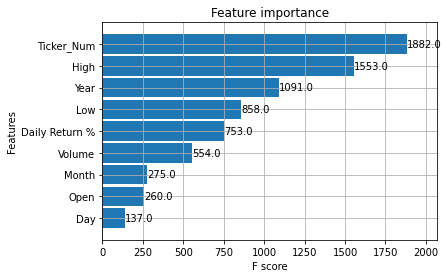

In [13]:
# Check feature importance
xgb.plot_importance(model, height=0.9)

In [14]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_eval)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


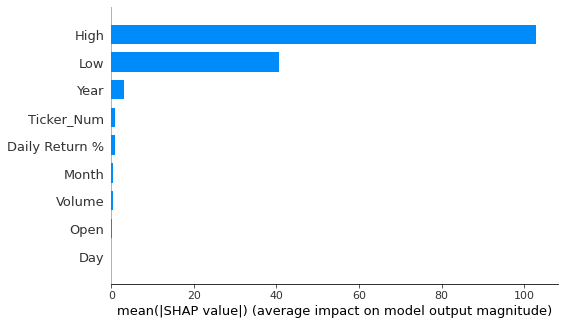

In [15]:
shap.summary_plot(shap_values, x_eval, plot_type="bar")

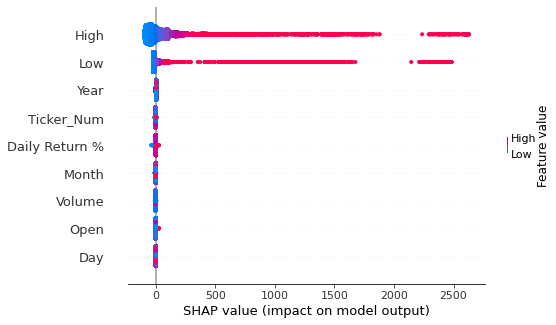

In [16]:
shap.summary_plot(shap_values, x_eval)

## Evaluate model

In [17]:
# Create a final dataframe to verify the predictions
df_pred = x_eval.copy()
# Recreate a column for the complete date
date_columns = ['Year', 'Month', 'Day']
df_pred['Date'] = pd.to_datetime(df_pred[date_columns])
df_pred.drop(date_columns, inplace=True, axis=1)

In [18]:
# Predict data for the eval dataset and save the predicted Adj Close as a new column
df_pred['Adj Close_Pred'] = model.predict(x_eval)

In [19]:
# Add the true Adj Close into the dataset
# Indexes were not reset, so we can join on the index (the indexes are reset during the merge though)
df_pred = df_pred.merge(
    y_eval, 
    how = 'inner', 
    left_index = True, 
    right_index = True
)
# As well as the ticker names
df_pred = df_pred.merge(
    tickers_df, 
    how = 'inner',
    left_on = 'Ticker_Num',
    right_on = 'Ticker Number'
)
df_pred.drop(['Ticker_Num', 'Ticker Number'], inplace=True, axis=1)

In [20]:
mse = mean_squared_error(
    y_true = df_pred['Adj Close'],
    y_pred = df_pred['Adj Close_Pred']
)
mae = mean_absolute_error(
    y_true = df_pred['Adj Close'],
    y_pred = df_pred['Adj Close_Pred']
)
# Mean Absolute Percentage Error is the percentage of how off the predicted values are
mape = (
    np.abs(df_pred['Adj Close'] - df_pred['Adj Close_Pred']) / df_pred['Adj Close']
).mean() * 100

print(f'Mean Squared Error is {round(mse, 2)}')
print(f'Mean Absolute Error is {round(mae, 2)}')
print(f'Mean Absolute Percentage Error is {round(mape, 2)}%')

Mean Squared Error is 140.28
Mean Absolute Error is 2.17
Mean Absolute Percentage Error is 1.41%


In [21]:
df_pred['Squared Error'] = (df_pred['Adj Close'] - df_pred['Adj Close_Pred']) ** 2
df_pred['Absolute Error'] = df_pred['Squared Error'].apply(np.abs)
df_pred['Absolute Percentage Error'] = (
    np.abs(df_pred['Adj Close'] - df_pred['Adj Close_Pred']) / df_pred['Adj Close']
) * 100

In [22]:
# Prepare data for visualisation
ticker = 'AMD'
df_pred_viz = df_pred.query('Ticker == @ticker')

df_pred_viz = df_pred_viz.melt(
    id_vars = ['Date', 'Ticker'],
    value_vars = ['Adj Close_Pred', 'Adj Close'],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = 'Date', 
    y = 'Value', 
    color = 'Value Type', 
    title = f'Adj Close: True vs. Predicted for {ticker}'
)
fig.show()

In [23]:
# Prepare data for visualisation
ticker = 'NVR'
df_pred_viz = df_pred.query('Ticker == @ticker')

df_pred_viz = df_pred_viz.melt(
    id_vars = ['Date', 'Ticker'],
    value_vars = ['Adj Close_Pred', 'Adj Close'],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = 'Date', 
    y = 'Value', 
    color = 'Value Type', 
    title = f'Adj Close: True vs. Predicted for {ticker}'
)
fig.show()

In [24]:
# Prepare data for visualisation
tickers = ['AMD', 'INTC']
df_pred_viz = df_pred.query('Ticker in @tickers')
df_pred_viz = df_pred_viz.melt(
    id_vars = ['Date', 'Ticker'],
    value_vars = ['Adj Close_Pred', 'Adj Close'],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = 'Date', 
    y = 'Value', 
    color = 'Value Type', 
    facet_row = 'Ticker',
    title = f'Adj Close: True vs. Predicted for {tickers}'
)
fig.show()

In [25]:
# Prepare data for visualisation
tickers = ['GOOG', 'AMZN', 'GOOGL']
df_pred_viz = df_pred.query('Ticker in @tickers')
df_pred_viz = df_pred_viz.melt(
    id_vars = ['Date', 'Ticker'],
    value_vars = ['Adj Close_Pred', 'Adj Close'],
    var_name = "Value Type",
    value_name = "Value"
)

fig = px.line(
    df_pred_viz, 
    x = 'Date', 
    y = 'Value', 
    color = 'Value Type', 
    facet_row = 'Ticker',
    title = f'Adj Close: True vs. Predicted for {tickers}'
)
fig.show()

In [31]:
# df_pred_viz = df_pred.query('Ticker != "NVR"')
df_pred_viz = df_pred\
    .groupby(['Ticker'])\
    .mean()[['Squared Error', 'Absolute Error', 'Absolute Percentage Error']]\
    .reset_index()\
    .sort_values(by = 'Absolute Percentage Error', ascending = False)
df_pred_viz

fig = px.bar(
    df_pred_viz.head(n=10), 
    x = 'Ticker', 
    y = 'Absolute Percentage Error', 
    title = 'Mean Absolute Percentage Error by Ticker (Top 10)'
)
fig.show()

In [27]:
df_pred_viz = df_pred.copy()
# This gets the first of the month for each date
df_pred_viz['Year Month'] = df_pred_viz['Date'].to_numpy().astype('datetime64[M]')

df_pred_viz = df_pred_viz\
    .groupby(['Year Month'])\
    .mean()[['Squared Error', 'Absolute Error', 'Absolute Percentage Error']]\
    .reset_index()

fig = px.line(
    df_pred_viz, 
    x = 'Year Month', 
    y = 'Absolute Percentage Error', 
    title = 'Mean Absolute Percentage Error by Month Year'
)
fig.show()

# Output model

In [28]:
model.save_model('sp500_xgboost.json')